In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

testIds = testDf['id']
trainDf.drop('id', axis=1, inplace=True)
testDf.drop('id', axis=1, inplace=True)

yTrain = trainDf['Depression']
xTrain = trainDf.drop('Depression', axis=1)
xTest = testDf.copy()

trainDf.dtypes

Name                                      object
Gender                                    object
Age                                        int64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                           int64
Financial Stress                           int64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [16]:
for column in trainDf.columns:
    print(f"\n=== {column} ===")
    print(trainDf[column].value_counts(dropna=False))


=== Name ===
Name
Rohan      19
Krishna    17
Sanya      17
Chhavi     16
Gauri      16
           ..
Lakshay     3
Mukund      3
Rajveer     3
Rupa        2
Aakash      2
Name: count, Length: 216, dtype: int64

=== Gender ===
Gender
Male      1004
Female     887
Name: count, dtype: int64

=== Age ===
Age
29    59
28    58
49    57
56    54
33    54
24    53
38    53
47    50
20    49
46    49
53    48
50    47
59    46
34    46
57    46
40    46
35    46
25    45
30    45
31    44
45    44
18    44
42    44
48    43
41    42
51    42
54    41
21    41
58    41
43    40
44    39
60    39
19    38
23    38
39    38
52    37
26    36
36    36
27    36
55    36
37    35
22    35
32    31
Name: count, dtype: int64

=== City ===
City
Srinagar         83
Pune             80
Meerut           78
Mumbai           72
Visakhapatnam    70
Kanpur           67
Indore           66
Chennai          66
Vasai-Virar      65
Patna            65
Surat            63
Bhopal           63
Ludhiana         62


# Data Processing

## Data correlation

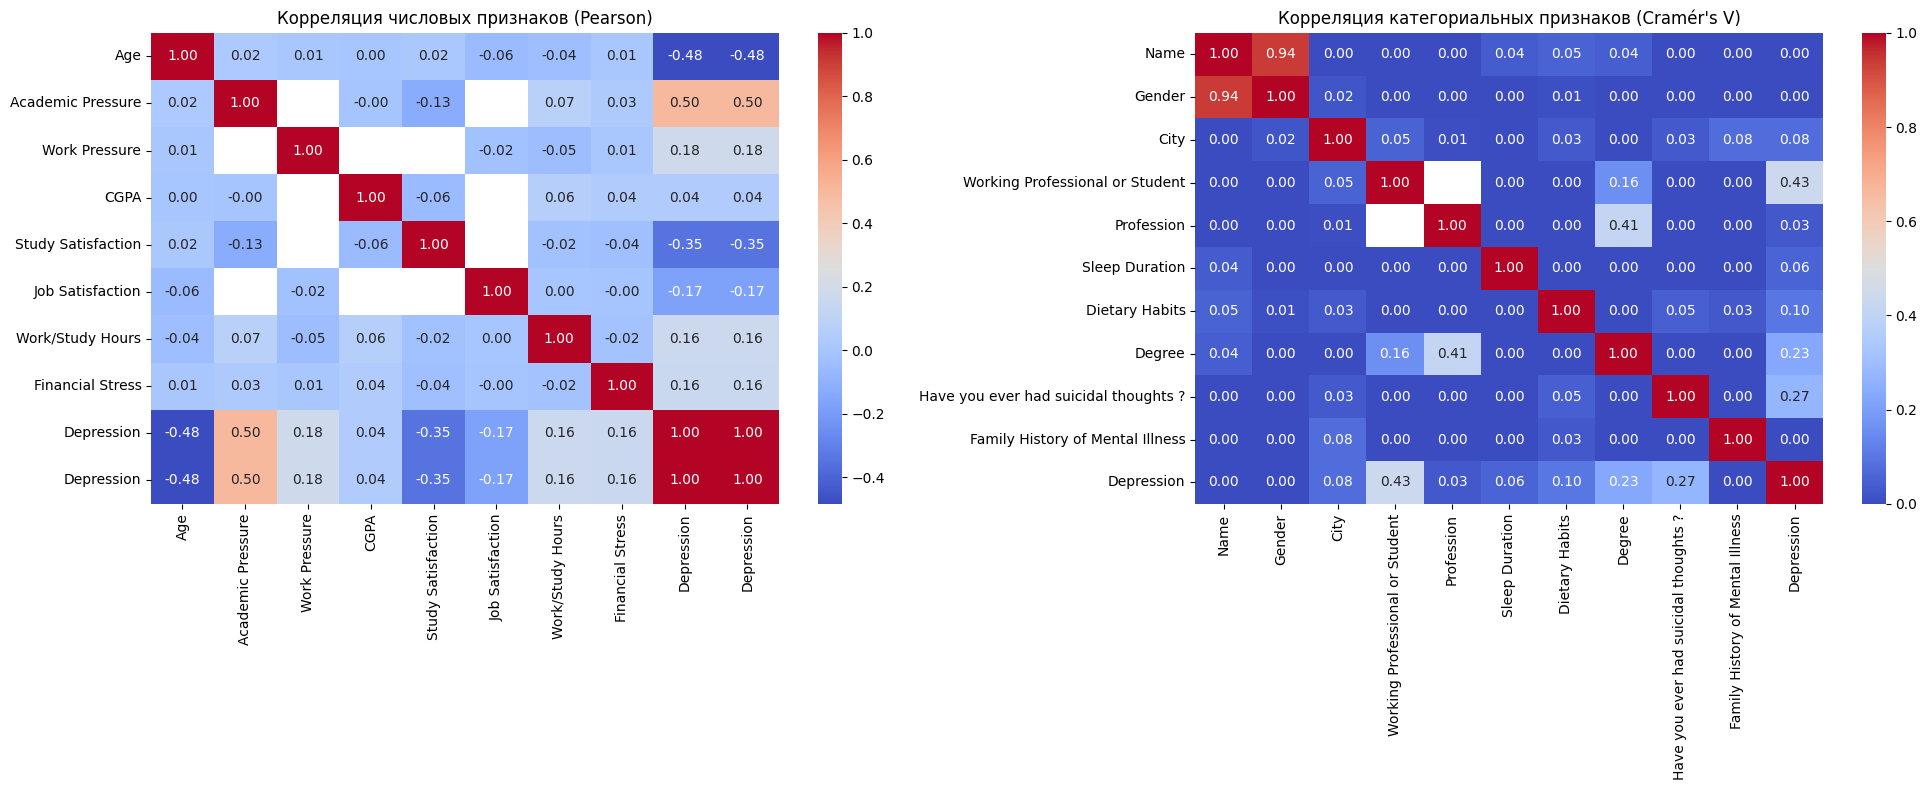

In [17]:
from scipy.stats import chi2_contingency

train = xTrain.copy()
train['Depression'] = yTrain

numCols = train.select_dtypes(exclude='object').columns.tolist()
catCols = train.select_dtypes(include='object').columns.tolist()

numColsCorr = numCols + ['Depression']
catColsCorr = catCols + ['Depression']

corrNum = train[numColsCorr].corr(method='pearson')

# === Cramér's V ===
def cramersV(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom == 0:
        return np.nan
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

corrCat = pd.DataFrame(index=catColsCorr, columns=catColsCorr)
for col1 in catColsCorr:
    for col2 in catColsCorr:
        try:
            corrCat.loc[col1, col2] = cramersV(train[col1], train[col2])
        except:
            corrCat.loc[col1, col2] = np.nan
corrCat = corrCat.astype(float)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(corrNum, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
axes[0].set_title("Корреляция числовых признаков (Pearson)")

sns.heatmap(corrCat, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title("Корреляция категориальных признаков (Cramér's V)")

plt.tight_layout()
plt.show()


## Missing Data

In [18]:
print("Missing values:")
print(trainDf.isnull().sum())

Missing values:
Name                                        0
Gender                                      0
Age                                         0
City                                        0
Working Professional or Student             0
Profession                                511
Academic Pressure                        1509
Work Pressure                             382
CGPA                                     1509
Study Satisfaction                       1509
Job Satisfaction                          382
Sleep Duration                              0
Dietary Habits                              0
Degree                                      0
Have you ever had suicidal thoughts ?       0
Work/Study Hours                            0
Financial Stress                            0
Family History of Mental Illness            0
Depression                                  0
dtype: int64


## Skew

In [19]:
from scipy.stats import skew
skewedCols = trainDf[numCols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewedCols})

display(skewness)

,Skew
Depression,1.681706
Financial Stress,0.036472
Academic Pressure,0.010386
Work Pressure,0.001083
Job Satisfaction,-0.003597
Age,-0.007530
CGPA,-0.022211
Work/Study Hours,-0.031340
Study Satisfaction,-0.038266


## Processing

In [20]:
xTrain = xTrain.drop(['Name', 'Gender', 'CGPA', 'City', 'Profession'], axis=1)
xTest = xTest.drop(['Name', 'Gender', 'CGPA', 'City', 'Profession'], axis=1)

catCols = xTrain.select_dtypes(include='object').columns.tolist()
numCols = xTrain.select_dtypes(exclude='object').columns.tolist()

numPipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

catPipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numPipeline, numCols),
    ("cat", catPipeline, catCols)
])

xTrainProcessed = preprocessor.fit_transform(xTrain)
xTestProcessed = preprocessor.transform(xTest)

## Models

In [21]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=200, solver='liblinear', penalty='l1', random_state=42),
    'KNN': KNeighborsClassifier(metric='manhattan'),
    'SVM': SVC(random_state=42, C=20000.1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=300)
}

## Accuracy

In [22]:
bestAcc = 0
bestModel = None
bestModelName = ''
results = {}

print("Model Accuracy Scores (train set):\n" + "-"*30)
for name, model in models.items():
    model.fit(xTrainProcessed, yTrain)

    yTrainPred = model.predict(xTrainProcessed)
    yTestPred = model.predict(xTestProcessed)

    acc = accuracy_score(yTrain, yTrainPred)
    print(f"{name:20s}: {acc:.4f}")

    if acc > bestAcc:
        bestAcc = acc
        bestModel = model
        bestModelName = name

    results[name] = {
        "model": model,
        "yTrainPred": yTrainPred,
        "yTestPred": yTestPred,
        "yTrainProba": model.predict_proba(xTrainProcessed)[:, 1] if hasattr(model, "predict_proba") else None,
        "yTestProba": model.predict_proba(xTestProcessed)[:, 1] if hasattr(model, "predict_proba") else None
    }

if 'Logistic Regression' in results:
    print("\nClassification Report (Logistic Regression):\n" + "-"*50)
    print(classification_report(yTrain, results['Logistic Regression']['yTrainPred']))

print(f"Best model: {bestModelName}\n")
testPreds = bestModel.predict(xTestProcessed)
submission = pd.DataFrame({
    'id': testIds,
    'Depression': testPreds
})
submission.to_csv('submission.csv', index=False)

Model Accuracy Scores (train set):
------------------------------
Logistic Regression : 1.0000
KNN                 : 0.9529
SVM                 : 1.0000
Decision Tree       : 1.0000
Random Forest       : 1.0000

Classification Report (Logistic Regression):
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1554
           1       1.00      1.00      1.00       337

    accuracy                           1.00      1891
   macro avg       1.00      1.00      1.00      1891
weighted avg       1.00      1.00      1.00      1891

Best model: Logistic Regression



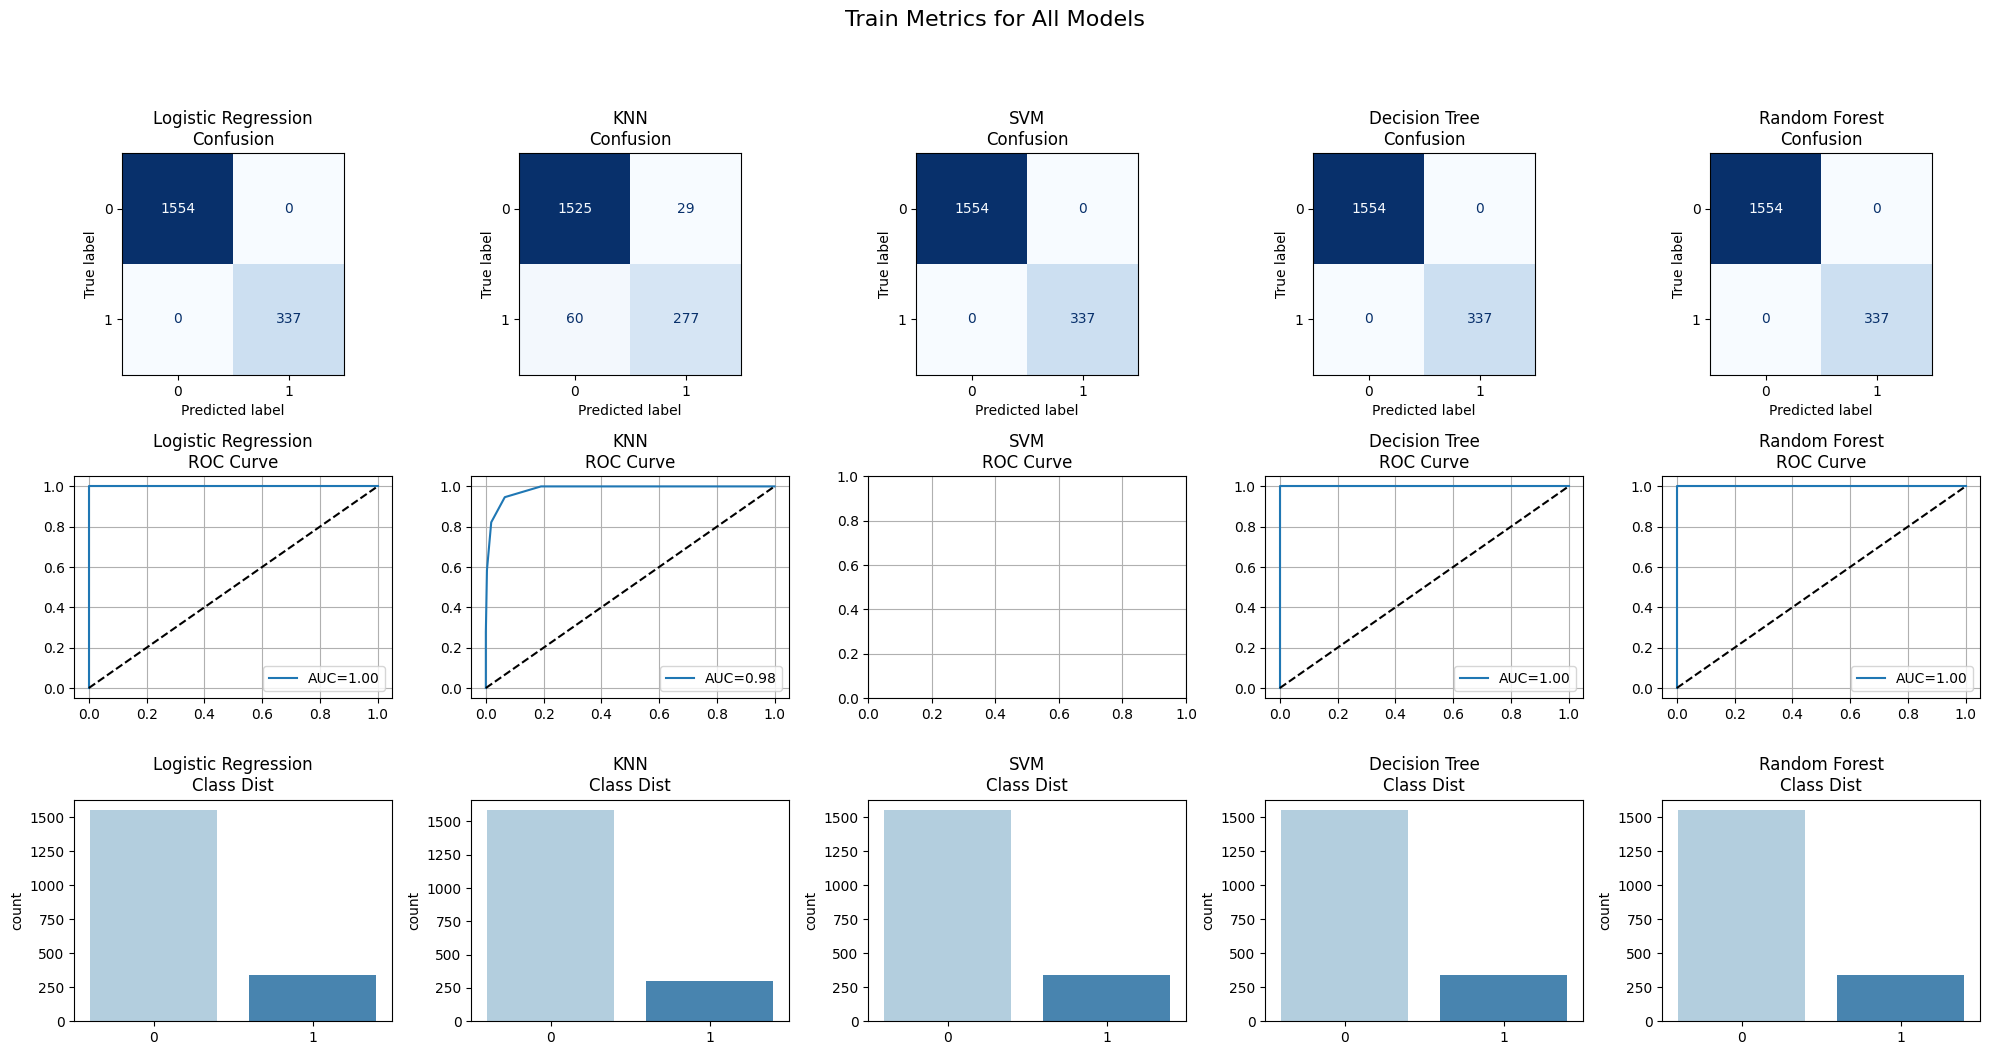

In [23]:
figTrain, axesTrain = plt.subplots(3, 5, figsize=(20, 10))
figTrain.suptitle("Train Metrics for All Models", fontsize=16, y=1.05)

for i, (name, result) in enumerate(results.items()):
    model = result["model"]
    yPred = result["yTrainPred"]
    yProba = result["yTrainProba"]

    cm = confusion_matrix(yTrain, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axesTrain[0, i], cmap='Blues', colorbar=False)
    axesTrain[0, i].set_title(f'{name}\nConfusion')

    if yProba is not None:
        fpr, tpr, _ = roc_curve(yTrain, yProba)
        auc_score = auc(fpr, tpr)
        axesTrain[1, i].plot(fpr, tpr, label=f"AUC={auc_score:.2f}")
        axesTrain[1, i].plot([0, 1], [0, 1], 'k--')
        axesTrain[1, i].legend()
    axesTrain[1, i].set_title(f'{name}\nROC Curve')
    axesTrain[1, i].grid(True)

    sns.countplot(x=yPred, hue=yPred, ax=axesTrain[2, i], palette='Blues', legend=False)
    axesTrain[2, i].set_title(f'{name}\nClass Dist')

plt.tight_layout()
plt.show()